# 2021 Wieviele Sitze Parteien haben und haben sollten

In [1]:
import pandas as pd
import numpy as np
import cleandata as cd
import matplotlib
from voting import apportionment

In [2]:
df_raw = pd.read_csv('../data/Gemeinde_Exekutive - daten.csv')
df_2019 = pd.read_csv('../data/kantonsrat2019.csv')

## Clean Data

In [3]:
df_raw = cd.clean(df_raw)

# Clean Gemeinde-Names for Join
df_raw['Gemeinde'] = df_raw['Gemeinde'].str.replace(' (ZH)', '', regex=False)

Jahrgänge nicht zugeordnet: 15
Partei nicht zugeordnet: 9
Keine Jahrgänge: 21


## Clean Kantonsratswahl

In [4]:
# Rename Wahlkreise
df_2019.loc[df_2019.Gemeindenamen.str.contains('Winterthur', regex=False), 'Gemeindenamen'] = 'Winterthur'
df_2019.loc[df_2019.Gemeindenamen.str.contains('Zürich, Kreis', regex=False), 'Gemeindenamen'] = 'Zürich'
df_2019.loc[df_2019.Gemeindenamen.str.contains('Ellikon a.d.Thur', regex=False), 'Gemeindenamen'] = 'Ellikon an der Thur'

# Transform
df_2019['partei_c'] = df_2019['Liste'].apply(cd.transform_partei)

# Group by Gemeinde
df_2019 = df_2019.groupby(['Gemeindenamen', 'partei_c']).agg({'Stimmen': 'sum'}).reset_index()

# Calc %
df_2019['2019'] = df_2019.apply(lambda row: round(100 / df_2019.loc[df_2019.Gemeindenamen == row['Gemeindenamen'], 'Stimmen'].sum() * row['Stimmen'], 2), axis=1)

df_2019.head()

,Gemeindenamen,partei_c,Stimmen,2019
0,Adlikon,al,7,0.84
1,Adlikon,bdp,45,5.38
2,Adlikon,cvp,6,0.72
3,Adlikon,edu,23,2.75
4,Adlikon,evp,52,6.22


## Calc "is"

In [30]:
df = df_raw.pivot_table(index='Gemeinde', columns='partei_c', values='Name', aggfunc='count')
df = df.fillna(0)
df.head()

partei_c,al,bdp,cvp,edu,evp,fdp,glp,grüne,parteilos,sp,svp,vacant,verschiedene
Gemeinde,,,,,,,,,,,,,
Adlikon,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0
Adliswil,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
Aesch,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0
Aeugst am Albis,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0
Affoltern am Albis,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,2.0,1.0,0.0,0.0


## Calc "should" - Loop di loop

In [22]:
records = []

for i, row in df_2019.groupby('Gemeindenamen').count().reset_index().iterrows():
    record = {'Gemeinde': row['Gemeindenamen']}
    
    df_g = df_2019[df_2019.Gemeindenamen == row['Gemeindenamen']].copy().reset_index()
    
    df_g['should'] = apportionment.hagenbach_bischoff(list(df_g['2019']), len(df_raw[df_raw.Gemeinde == row['Gemeindenamen']]))
    
    for i, row in df_g[df_g.should > 0].sort_values('should', ascending=False).iterrows():
        record[row['partei_c']] = row['should']
        
    records.append(record)

df_should = pd.DataFrame(records)
df_should = df_should.fillna(0)

## Merge

In [51]:
# Group should
df_s = df_should.drop(columns='Gemeinde')
df_s = pd.DataFrame(df_s.sum())
df_s.rename(columns={0: 'should'}, inplace=True)

# Group is
df_i = df.reset_index(drop=True)
df_i = pd.DataFrame(df_i.sum())
df_i.rename(columns={0: 'is'}, inplace=True)

df_joined = df_i.join(df_s)
df_joined = df_joined.fillna(0)

# Calc dif
df_joined['diff'] = df_joined['should'] - df_joined['is']

df_joined

,is,should,diff
partei_c,,,
al,1.0,1.0,0.0
bdp,4.0,1.0,-3.0
cvp,44.0,5.0,-39.0
edu,1.0,4.0,3.0
evp,20.0,12.0,-8.0
fdp,220.0,181.0,-39.0
glp,34.0,120.0,86.0
grüne,10.0,64.0,54.0
parteilos,364.0,0.0,-364.0


<AxesSubplot:xlabel='partei_c'>

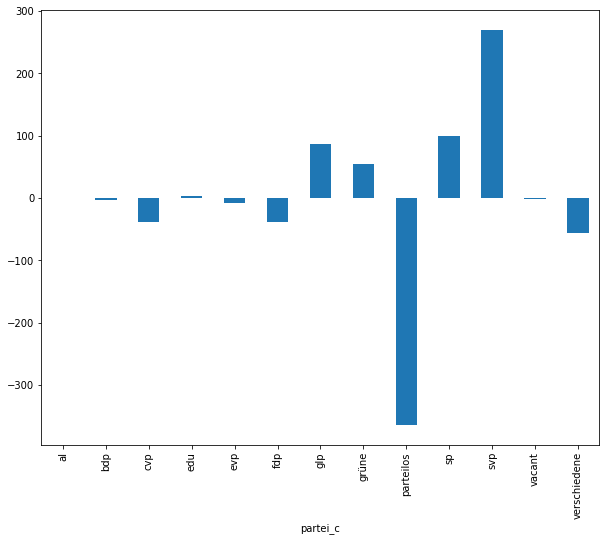

In [56]:
df_joined['diff'].plot.bar(figsize=(10, 8))